In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

In [2]:
def get_stock_data(ticker,start,end):
    df = web.get_data_yahoo(ticker,start = start , end = end)
    return df

In [3]:
ticker = 'AAPL'
start = datetime(2016,1,11)
end = datetime(2020,1,11)
APPLE = get_stock_data(ticker,start,end)
print(APPLE.tail())

                  High         Low        Open       Close      Volume  \
Date                                                                     
2020-01-06  299.959991  292.750000  293.790009  299.799988  29596800.0   
2020-01-07  300.899994  297.480011  299.839996  298.390015  27218000.0   
2020-01-08  304.440002  297.160004  297.160004  303.190002  33019800.0   
2020-01-09  310.429993  306.200012  307.239990  309.630005  42527100.0   
2020-01-10  312.670013  308.250000  310.600006  310.329987  35161200.0   

             Adj Close  
Date                    
2020-01-06  298.282715  
2020-01-07  296.879883  
2020-01-08  301.655548  
2020-01-09  308.062988  
2020-01-10  308.759399  


In [4]:
def stock_features(df):
    df["SMA_5"] = df["Close"].rolling(5).mean()
    df["SMA_20"] = df["Close"].rolling(20).mean()   
    df['Long_Entry']=0
    df['Long_Exit']=0
    df['Short_Entry']=0
    df['Short_Exit']=0
    df = df.dropna()
    return df

In [5]:
apple = APPLE.copy()
apple1 = stock_features(apple)

In [6]:
def SMA_Strategy(df):
    signal = 0 
    ret = []
    
    for i in range(len(df)):
        
        if (signal== 0):
            ret.append(0)
            #Long_Entry:
            
            if(df['SMA_5'][i] > df['SMA_20'][i]
               and df['SMA_5'][i-1] < df['SMA_20'][i-1]):
                signal = 1
                df["Long_Entry"][i] = df["Close"][i]
            
            #Short_Entry:
            
            elif(df['SMA_5'][i] > df['Close'][i]
               and df['SMA_5'][i-1] < df['Close'][i-1]): 
                signal = -1
                df["Short_Entry"][i] = df["Close"][i]
             
            #Long_Exit
            
        elif (signal == 1):
                if(df['SMA_5'][i] > df['Close'][i]
                   and df['SMA_5'][i-1] < df['Close'][i-1]):
                    signal = 0
                    df['Long_Exit'][i] = df['Close'][i]
                    ret.append((df['Close'][i]/df['Close'][i-1]-1))
                else:
                    ret.append((df['Close'][i]/df['Close'][i-1]-1))
            
            #Short_Exit
        elif (signal == -1):
                if(df['Close'][i] < df['SMA_5'][i]
                   and df['Close'][i-1] > df['SMA_5'][i-1]):
                    signal = 0
                    df['Short_Exit'][i] = df['Close'][i]
                    ret.append(1-df['Close'][i]/df['Close'][i-1])
                else:
                    ret.append(1-df['Close'][i]/df['Close'][i-1])       
                
    df["ret"] = np.array(ret)
    return df

In [7]:
apple2 = apple1.copy()
apple3 = SMA_Strategy(apple2)

C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\kunal\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A valu

In [8]:
apple3.to_csv("APPLE_DAMN.csv")

In [9]:
def CAGR(df):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"

    
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df['cum_return'].plot(figsize=(15,8),grid=True)
    plt.ylabel('Cumm_Returns')
    plt.xlabel('Date')
    print("Cumm_returns",(df["cum_return"][-1]-1)*100,"%")
    
    n = len(df)/(252)   
    CAGR = ((df["cum_return"][-1])**(1/n) - 1)
    return CAGR

def volatility(df):
    "function to calculate annualized volatility of a trading strategy"
    vol = (df["ret"].std() * np.sqrt(252))
    return vol

def sharpe(df,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(df):
    "function to calculate max drawdown"
    
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


Cumm_returns -34.07945327745551 %
Cumm_returns -34.07945327745551 %
   Annual_Return  Volatility  Sharpe Ratio  Max Drawdown
0      -0.100739    0.159896     -0.630024      0.411194


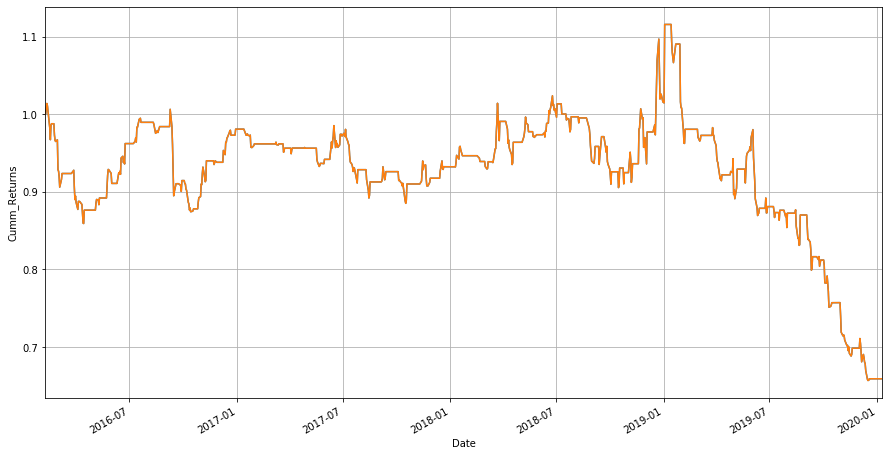

In [10]:

cagr = CAGR(apple3)
Volatility = volatility(apple3)
sharpe_ratio = sharpe(apple3,0.0)
Max_drawdown = max_dd(apple3)

Portfolio_df = pd.DataFrame([cagr,Volatility,sharpe_ratio,Max_drawdown],index=["Annual_Return","Volatility","Sharpe Ratio","Max Drawdown"])      
print(Portfolio_df.T)